In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline
from skimage import io, color
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf  
from keras.utils import to_categorical
import glob
import re
from tensorflow.python.keras import applications
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential,Model,load_model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.python.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint


from keras.applications.vgg16 import VGG16
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# mount drive on Google drive to access training data
# Ignore this if you don't use Google Colab
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Access training data in My Drive
train_path = "/content/drive/My Drive/ECE542_sp20_CompetitionData/TrainData-C2/"
# get training labels
train_labels = pd.read_csv("/content/drive/My Drive/ECE542_sp20_CompetitionData/TrainData-C2/TrainAnnotations.csv")
train_labels.sort_values(by=["file_name"], inplace=True)
train_files = glob.glob(train_path + "*.jpg")
train_files.sort()

In [0]:
#sanity check
train_labels.annotation[100]
print(train_labels.file_name[100])
print(train_files[100])
re.sub(train_path, "", train_files[100])

002191.jpg
/content/drive/My Drive/ECE542_sp20_CompetitionData/TrainData-C2/002191.jpg


'002191.jpg'

# Helper functions

In [0]:
def extract_data(file_names, labels, size=None):
  """
  Extract all images given list of file names and list of labels.  Also resize
  images according to user-defined size
  Inputs:
  - filenames: list of file paths to images
  - labels: list of label of each image; order based on the order of filenames
  Outputs:
  - images: list of RGB images
  - annotations: list of labels for the images
  """
  images = []
  annotations = []
  for idx, f in enumerate(file_names):
    img = io.imread(f)
    if size is not None:
      img = resize(img, (size, size), anti_aliasing=True)
    images.append(img)
    annotations.append(labels[idx])
  return images, annotations

In [0]:
def RGB2HUE(images):
  """
  Convert all RGB images into HSV channel
  Input:
  - images: list of images of shape (H, W, 3)
  """
  hue = []
  for img in images:
    hue.append(color.rgb2hsv(img))
  return hue

In [0]:
def df_to_array(df, output_shape):
  """
  Assuming the last column is the target column
  Convert dataframe of images (flatten) to arrays of images in shape (H, W, 3)
  Inputs:
  - df: dataframe of flatten images
  - output_shape: tuple of the shape of a single image (H, W, 3)
  """
  X = []
  pixel_matrix = df.iloc[:,:-1].values
  X = [pixel_matrix[i].reshape(output_shape) for i in range(len(pixel_matrix))]
  return np.array(X), df.iloc[:,-1].values

In [0]:
# This cell may take awhile to run
# extract all data
images, labels = extract_data(train_files, train_labels.annotation, 224)

# convert images to HSV (uncomment if needed)
#HSV = RGB2HSV(images)

#convert images to HUE (uncomment if needed)
HSV = RGB2HUE(images)


In [0]:
# # Get training and validation without augmentation or sampling
# X = np.array(HUE)
# X = X.reshape(1275, 224, 224, 1) # need to avoid the dimension error
# Y = to_categorical(labels)
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=31)




# Get training and validation without augmentation or sampling
# X = np.array(HUE)
# print(X.shape)
# X = X.reshape(1275, 224, 224, 1) # need to avoid the dimension error
Y = to_categorical(labels)
X = np.array(HSV)



X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=32)

original_shape = X_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))

# # transform the dataset
oversample = SMOTE(random_state=32)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [0]:
X_val_original_shape = X_val.shape
X_val =  np.reshape(X_val, (X_val.shape[0], X_val.shape[1]*X_val.shape[2]*X_val.shape[3]))
from imblearn.under_sampling import ClusterCentroids

# X_val = np.reshape(X_val, (383, original_shape[1],
#                                original_shape[2], original_shape[3]))
cc = ClusterCentroids(random_state=32)

X_val, Y_val = cc.fit_resample(X_val, Y_val)

X_val = np.reshape(X_val, (190, X_val_original_shape[1],
                               X_val_original_shape[2], X_val_original_shape[3]))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
print(X_train.shape)
X_train = np.reshape(X_train, (1675, original_shape[1],
                               original_shape[2], original_shape[3]))
print(X_train.shape)

(1675, 150528)
(1675, 224, 224, 3)


In [0]:
# class distribution of training and validation sets
print(np.sum(Y_train, axis=0))
print(np.sum(Y_val, axis=0))

[335 335 335 335 335]
[38 38 38 38 38]


In [0]:
vgg16_base = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

In [0]:
from keras import models
from keras import layers
from keras import optimizers

vgg16_model = models.Sequential()
 
# Add the vgg convolutional base model
vgg16_model.add(vgg16_base)
 
# Add new layers
#model.add(layers.Flatten())

# vgg16_model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
vgg16_model.add(layers.Dropout(0.7))
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(5, activation='softmax'))  

In [0]:
adam = Adam(lr=0.0001)
sgd = SGD(lr=0.01, momentum=0.9)
vgg16_model.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
print(vgg16_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 125445    
Total params: 14,840,133
Trainable params: 14,840,133
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
vgg16_fit = vgg16_model.fit(X_train, Y_train, epochs=12, batch_size=32, validation_data=(X_val, Y_val), verbose=1)

Train on 1675 samples, validate on 190 samples
Epoch 1/12
1675/1675 [==============================] - 309s 184ms/step - loss: 1.6112 - accuracy: 0.1952 - val_loss: 1.6103 - val_accuracy: 0.2000
Epoch 2/12
1675/1675 [==============================] - 309s 184ms/step - loss: 1.6117 - accuracy: 0.1881 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/12
1675/1675 [==============================] - 310s 185ms/step - loss: 1.6120 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 4/12
1675/1675 [==============================] - 308s 184ms/step - loss: 1.6075 - accuracy: 0.2078 - val_loss: 1.5842 - val_accuracy: 0.2158
Epoch 5/12
1675/1675 [==============================] - 308s 184ms/step - loss: 1.6051 - accuracy: 0.2101 - val_loss: 1.6100 - val_accuracy: 0.2000
Epoch 6/12
1675/1675 [==============================] - 312s 186ms/step - loss: 1.6114 - accuracy: 0.1809 - val_loss: 1.6100 - val_accuracy: 0.2000
Epoch 7/12
1675/1675 [==============================] - 312s 186m

In [0]:
# save model. always run this
vgg16_model.save("VGG16_HSV.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


<Figure size 432x288 with 0 Axes>

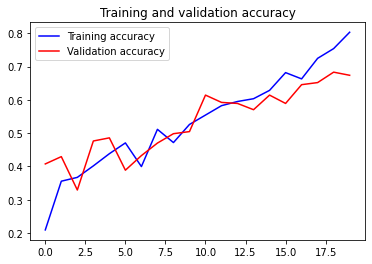

<Figure size 432x288 with 0 Axes>

In [0]:
accuracy = vgg16_fit.history['accuracy']
val_accuracy = vgg16_fit.history['val_accuracy']
loss = vgg16_fit.history['loss']
val_loss = vgg16_fit.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Make prediction on the test set

In [0]:
# Loading the test set
# Access testing data in My Drive
test_path = "/content/drive/My Drive/ECE542_sp20_CompetitionData/TestData/"
test_files = glob.glob(test_path + "*.jpg")
test_files.sort()

In [0]:
# Load all testing data and convert them into hsv 
test_data = []
for f in test_files:
  img = io.imread(f)
  # rescale images to half original size
  img = resize(img, (224, 224), anti_aliasing=True)
  #hsv = color.rgb2hsv(img)
  hue = color.rgb2hsv(img)[:,:,0]
  test_data.append(hue)

In [0]:
# making prediction
test_data = np.array(test_data)
test_data = test_data.reshape(200, 224, 224, 1)
predict = vgg16_model.predict(np.array(test_data))
Yhat = np.argmax(predict, axis=1)

In [0]:
print(Yhat)
np.sum(to_categorical(Yhat), axis=0)

[1 1 4 0 4 4 4 1 1 1 1 4 1 4 1 1 4 1 1 1 1 4 1 1 4 0 1 1 2 1 1 0 1 4 1 1 4
 1 1 0 1 4 1 1 1 1 1 1 1 1 1 1 1 4 4 4 0 4 0 1 1 1 4 4 1 4 4 2 4 1 4 4 4 1
 1 1 4 4 1 1 1 4 4 2 1 1 1 1 1 1 4 1 4 1 1 4 1 4 1 4 4 4 4 4 1 1 1 1 1 1 1
 4 4 1 4 4 1 1 1 4 1 1 1 4 1 4 1 4 1 4 1 4 4 1 4 4 0 1 1 1 4 1 1 0 1 1 0 1
 1 4 1 1 4 0 4 1 1 4 1 1 4 0 1 0 1 1 4 4 1 1 4 4 1 1 1 1 4 4 4 4 1 1 4 1 4
 1 0 1 4 1 1 4 1 4 1 0 4 1 1 1]


array([ 14., 113.,   3.,   0.,  70.], dtype=float32)